# README

This notebook is intended to serve as a test site for code related to experimenting with the ECCO bird data and simulated drone data. 

The notebook is organized by sections as follows:
<ol type="I">
    <li><b>General:</b> code meant to be used across all of the sections (e.g., imports, common constants, helper functions, etc.).
    <li><b>Preprocessing:</b> anything having to do with preprocessing the datasets (e.g., dropping columns, reformatting fields, etc.).
    <li><b>Principal Component Analysis:</b> dedicated to analyzing data with PCA.
    <li><b>Comparing Classifiers:</b>: testing different classifiers and comparing for accuracy. 
</ol>

These sections are meant to be (more or less) independent of each other. For example, <b>Principal Component Analysis</b> doesn't need to be run before <b>Comparing Classifiers</b>. You can choose which preprocessing cells to run depending on your needs.


# I. General

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid
import numpy as np
import random

from datetime import datetime
from sklearn import metrics, svm, tree
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from geopy import distance 
import math

### Constants

In [2]:
# ecco fields deemed not important by aaron
NI_ECCO = ['User Edit Time', 'Type', 'Associated UUID', 'Note', 'Combat ID', 
           'Creator', 'Editor', 'AZ', 'Range', '2525', 'Closest Distance', 
           'Course', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 'AIS Ship Type', 
           'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks']

NI_GPS = ['datetime(utc)', 'height_above_takeoff(feet)', 
          'height_above_ground_at_drone_location(feet)', 
          'ground_elevation_at_drone_location(feet)', 
          'height_sonar(feet)', 'distance(feet)', 'mileage(feet)',
          'satellites', 'gpslevel', 'voltage(v)', 'max_altitude(feet)',
          'max_ascent(feet)', 'max_speed(mph)', 'max_distance(feet)',
          ' xSpeed(mph)', ' ySpeed(mph)', ' zSpeed(mph)', ' compass_heading(degrees)', 
          ' pitch(degrees)', ' roll(degrees)', 'isPhoto', 'isVideo', 'rc_elevator',
          'rc_aileron', 'rc_throttle', 'rc_rudder', 'rc_elevator(percent)', 'rc_aileron(percent)',
          'rc_throttle(percent)', 'rc_rudder(percent)', 'gimbal_heading(degrees)',
          'gimbal_pitch(degrees)', 'gimbal_roll(degrees)', 'battery_percent',
          'voltageCell1', 'voltageCell2', 'voltageCell3', 'voltageCell4',
          'voltageCell5', 'voltageCell6', 'current(A)', 'battery_temperature(f)',
          'altitude(feet)', 'ascent(feet)', 'flycStateRaw', 'flycState', 'message']

# fields that only have one or two unique values:
# Source Name:  ['RPS82-90deg' 'ctcve']
# Source Class: ['RADAR']
# Source LID:   [21. 49.]
# Closest Time: [0.]
REPEAT_ECCO = ['Source Name', 'Source Class', 'Source LID', 'Closest Time']

# all other ecco fields (aside from position, velocity, heading)
OTHER_ECCO = ['Name', 'Create Time', 'Object ID', 'Origin Position (lat)',
              'Origin Position (lon)', 'Origin Position (alt MSL)', 'Radar Cross Section',
              'Source ID', 'Deleted', 'Deleted Time']

# the ecco fields related to time
TIME_COLS = ['Create Time', 'Update Time', 'Deleted Time']

# mapping between ecco and simulated
ECCO_SIMU_MAP = {
    'Update Time': 'UpdateTime',
    'Range To Contact': 'Range',
    'Bearing To Contact': 'AZ',
    'EL': 'EL',
    'Position (lat)': 'Position_lat_',
    'Position (lon)': 'Position_lon_',
    'Position (alt MSL)': 'Position_altMSL_',
    'Speed': 'Speed',
    'Radial Velocity': 'RadialVelocity'
}

GPS_MAP = {
    'time(millisecond)': 'UpdateTime',
    'latitude': 'Position_lat_',
    'longitude': 'Position_lon_',
    'altitude_above_seaLevel(feet)': 'Position_altMSL_',
    'speed(mph)': 'Speed',
}


### Helper Functions

In [3]:
# prints a summary of each dataframe passed in
# - dfs: a list of pandas dataframes
def printInfo(dfs):
    for df in dfs:
        print(df.info())
        print('\n======================================================\n')

# reformats the time columns in ecco
# time_str: a time value from ecco (formatted as a string)
def formatTime(time_str):
    # convert the time (a string) to a datetime
    time_obj = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    return time_obj

# compares a set of predictions to true labels and prints accuracy
def printAccuracy(y_pred, y_true):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    print(f'accuracy = {100 * accuracy}\n')

def fitDistribution(sampleList, targetList):
    mu1 = np.mean(targetList)
    mu2 = np.mean(sampleList)
    var1 = np.var(targetList)
    var2 = np.var(sampleList)

    scale = np.sqrt(var2/var1)
    shift = mu2 - scale*mu1

    scaledList = targetList*scale + shift
    return scaledList

def findRange(lat1, lon1, alt1, lat2, lon2, alt2):
    dist2d = distance.distance([lat1, lon1], [lat2, lon2]).m
    dist3d = np.sqrt(dist2d**2 + (alt2 - alt1)**2)
    return np.abs(dist3d)

def findBearing(lat1, lon1, lat2, lon2):
    brng = np.arctan((lon2-lon1)/(lat2-lat1)) * 360 /2 / math.pi
    if brng < 0: brng+= 360
    return brng

def findElevation(lat1, lon1, alt1, lat2, lon2, alt2):
    dist2d = distance.distance([lat1, lon1], [lat2, lon2]).m
    elevationAngle = np.arctan((alt2 - alt1)/dist2d) * 360 / 2 / math.pi
    return elevationAngle

def findRadialVelocity(vecX1, vecY1, vecX2, vecY2):
    diffX = vecX2-vecX1
    diffY = vecY2-vecY1
    return np.sqrt(diffX**2 + diffY**2)

### Load and process GPS data

In [7]:
## load ecco dataset
#df_ecco = pd.read_csv('..\data/raw/ecco.csv')
#df_ecco.name = 'ecco.csv'

# load gps data
gpsTracks = []
finalTracks = []
gpsData = ['..\data/raw/gps/GPSData1.csv', '..\data/raw/gps/GPSData2.csv', '..\data/raw/gps/GPSData3.csv', '..\data/raw/gps/GPSData4.csv', '..\data/raw/gps/GPSData5.csv', '..\data/raw/gps/GPSData6.csv']

generativeCycles = 10
scalingRange = [0.5, 2.5]

#Take every 10th row from each .csv (1s intervals), leaving out first and last 10 seconds
for data in gpsData:
    gpsTracks.append(pd.read_csv(data).iloc[200:-200:10, :])

for rep in range(generativeCycles):
    for track in gpsTracks:
        data = track.copy()

        track_IDs = [None] * len(data)
        ranges = [None] * len(data)
        bearings = [None] * len(data)
        elevations = [None] * len(data)
        radialVels = [None] * len(data)

        latNew = [None] * len(data)
        longNew = [None] * len(data)
        altNew = [None] * len(data)

        radarLat = np.random.uniform(-0.04, 0.04) + data['latitude'].iat[0]
        radarLon = np.random.uniform(-0.04, 0.04) + data['longitude'].iat[0]
        radarAlt = np.random.uniform(-200, 200) + data['altitude_above_seaLevel(feet)'].iat[0]
        scale = scalingRange[0] + (scalingRange[1]-scalingRange[0])/generativeCycles*rep

        lastDiffX = 0
        lastDiffY = 0

        #Speed/Distance scaling
        latNew[0] = data['latitude'].iat[0]
        longNew[0] = data['longitude'].iat[0]
        altNew[0] = data['altitude_above_seaLevel(feet)'].iat[0]

        for i in range(len(data)-1):
            latNew[i+1] = scale*(data['latitude'].iat[i+1]-data['latitude'].iat[i]) + latNew[i]
            longNew[i+1] = scale*(data['longitude'].iat[i+1]-data['longitude'].iat[i]) + longNew[i]
            altNew[i+1] = scale*(data['altitude_above_seaLevel(feet)'].iat[i+1]-data['altitude_above_seaLevel(feet)'].iat[i]) + altNew[i]
            #if (data['speed(mph)'].iat[i] == 0):
            #    data['speed(mph)'].iat[i] = distance.distance([data['longitude'].iat[i+1], data['latitude'].iat[i+1]], [data['longitude'].iat[i], data['latitude'].iat[i]]).m

        data['latitude'] = latNew
        data['longitude'] = longNew
        data['altitude_above_seaLevel(feet)'] = altNew
        data['speed(mph)'] *= scale

        #Split every 20th track
        for i in range(len(data)):

            #Splitting tracks into multiple UUIDs
            if i % 20 == 0:
                if(i+20 < len(data)):
                    id = str(uuid.uuid1())

            #Calculation of range, bearing, elevation angle
            track_IDs[i] = id
            ranges[i] = findRange(data['latitude'].iat[i], data['longitude'].iat[i], data['altitude_above_seaLevel(feet)'].iat[i],
                                radarLat, radarLon, radarAlt)
            bearings[i] = findBearing(data['latitude'].iat[i], data['longitude'].iat[i],
                                radarLat, radarLon)
            elevations[i] = findElevation(data['latitude'].iat[i], data['longitude'].iat[i], data['altitude_above_seaLevel(feet)'].iat[i],
                                radarLat, radarLon, radarAlt)
            
            currentDiffX = distance.distance([data['latitude'].iat[i], 0], [radarLat, 0]).m
            currentDiffY = distance.distance([data['longitude'].iat[i], 0], [radarLon, 0]).m

            radialVels[i] = findRadialVelocity(lastDiffX, lastDiffY, currentDiffX, currentDiffY)

            lastDiffX = currentDiffX
            lastDiffY = currentDiffY

            # speed unit conversion
            data['speed(mph)'].iat[i]*=0.44704

        data['UUID'] = track_IDs
        data['Range'] = ranges
        data['AZ'] = bearings
        data['EL'] = elevations
        
        # Wasn't letting me drop first row during iteration idk why
        radialVels[0] = radialVels[1]
        data['RadialVelocity'] = radialVels

        finalTracks.append(data)
        
        #Add reversed track
        data_r = data.copy()
        data_r['speed(mph)'] = data['speed(mph)'].shift(1)
        data_r['time(millisecond)'] = data['time(millisecond)'].values[::-1]

        finalTracks.append(data_r.iloc[1:])

df_gps = pd.concat(finalTracks, ignore_index=True)
df_gps = df_gps.sort_values(by='time(millisecond)', ascending=True)
df_gps.name = 'gpsData.csv'

# drop unimportant columns from gps data
df_gps = df_gps.drop(columns=NI_GPS)
    
# rename all of the gps columns to match ecco
df_gps = df_gps.rename(columns=GPS_MAP, errors='raise')

# show dataframe
df_gps

,UpdateTime,Position_lat_,Position_lon_,Position_altMSL_,Speed,UUID,Range,AZ,EL,RadialVelocity
0,234500,40.429350,-86.929374,645.496329,3.390006,7ca467c7-cb6b-11ee-8af2-cc153123845c,3432.659249,337.546178,1.785063,3.708037
354,234500,40.429182,-86.929333,637.130187,0.000000,7cc1a851-cb6b-11ee-9e64-cc153123845c,3451.765074,337.592831,1.914121,0.026924
1,235500,40.429380,-86.929389,646.808665,3.780006,7ca467c7-cb6b-11ee-8af2-cc153123845c,3429.081945,337.550601,1.764988,3.708037
353,235500,40.429182,-86.929333,637.130187,0.050000,7cc1a851-cb6b-11ee-9e64-cc153123845c,3451.764812,337.593256,1.914121,0.028027
2,236500,40.429414,-86.929404,647.628875,4.190007,7ca467c7-cb6b-11ee-8af2-cc153123845c,3425.082387,337.552381,1.753322,4.125254
...,...,...,...,...,...,...,...,...,...,...
175,409600,40.429182,-86.929333,636.966145,0.050000,7cc1a851-cb6b-11ee-9e64-cc153123845c,3451.769337,337.592811,1.916843,0.125737
179,409600,40.429414,-86.929404,647.628875,3.780006,7ca467c7-cb6b-11ee-8af2-cc153123845c,3425.082387,337.552381,1.753322,4.125254
178,410600,40.429380,-86.929389,646.808665,3.390006,7ca467c7-cb6b-11ee-8af2-cc153123845c,3429.081945,337.550601,1.764988,3.708037
176,410600,40.429182,-86.929333,637.130187,0.000000,7cc1a851-cb6b-11ee-9e64-cc153123845c,3451.764812,337.593256,1.914121,0.028027


### Save new CSV

In [5]:
df_gps.to_csv('..\data/raw/gps/processedGPSData.csv', index=False)

### Plot Data

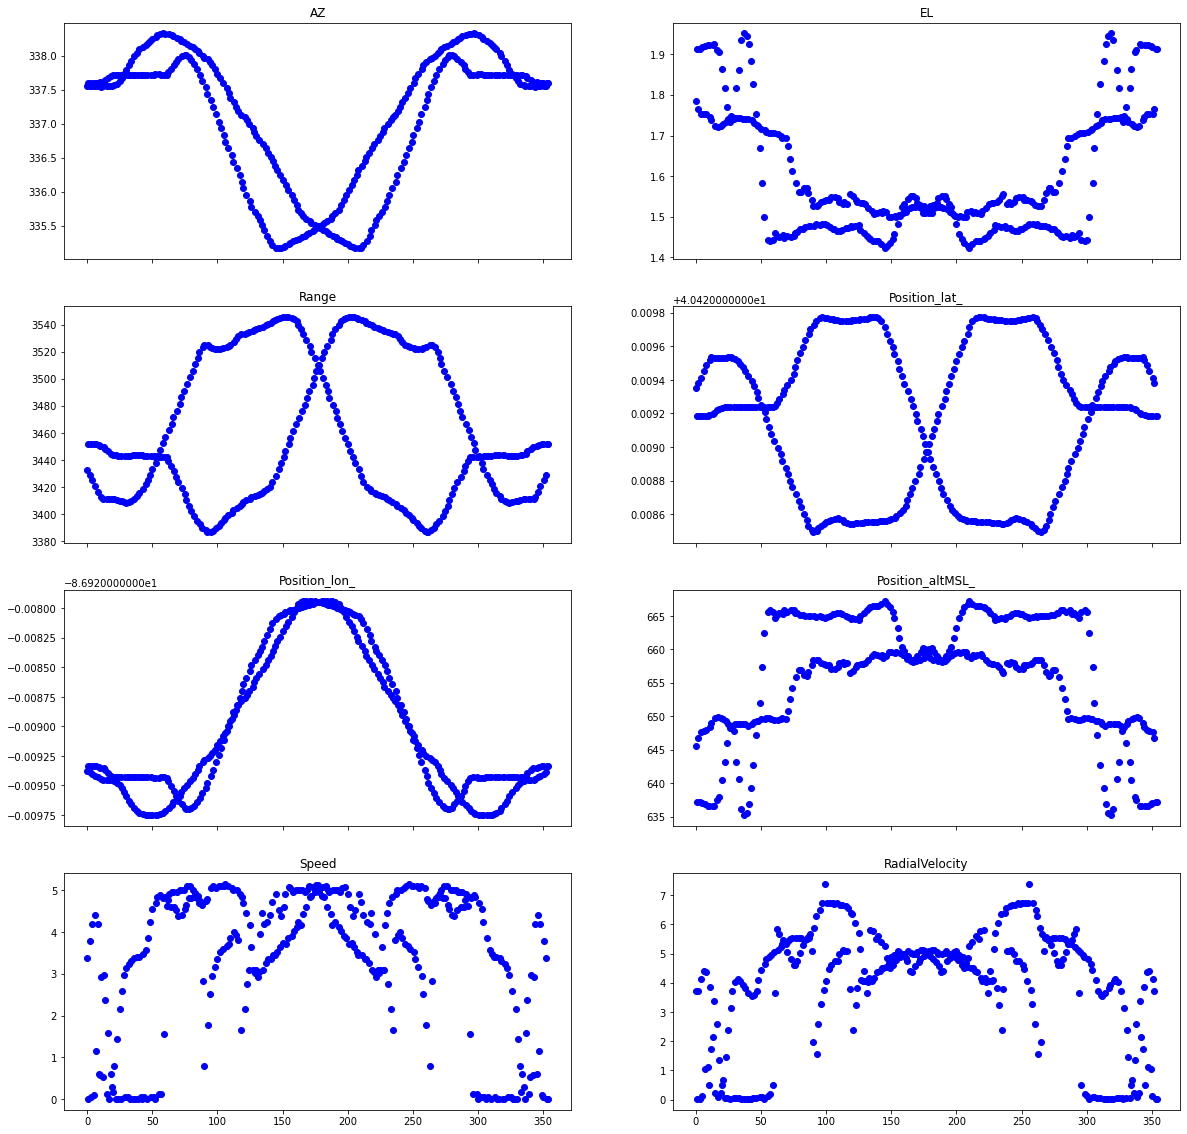

In [8]:
graph = ['AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity']

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20,20), sharex=True)

for i, ax in enumerate(axes.flatten()):
    plot = ax.scatter(np.arange(len(df_gps['RadialVelocity'])), df_gps[graph[i]], c='blue')
    ax.set_title(graph[i])